<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Amazonas-mit-Welt-Kacheln" data-toc-modified-id="Amazonas-mit-Welt-Kacheln-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Amazonas mit Welt-Kacheln</a></span><ul class="toc-item"><li><span><a href="#Hinweis:-Kacheln-erstellen" data-toc-modified-id="Hinweis:-Kacheln-erstellen-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Hinweis: Kacheln erstellen</a></span></li><li><span><a href="#Was-ist-multilabel?" data-toc-modified-id="Was-ist-multilabel?-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Was ist multilabel?</a></span></li><li><span><a href="#Weitere-Schritte..." data-toc-modified-id="Weitere-Schritte...-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Weitere Schritte...</a></span></li><li><span><a href="#Exportiertes-Modell-verwenden" data-toc-modified-id="Exportiertes-Modell-verwenden-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Exportiertes Modell verwenden</a></span></li></ul></li></ul></div>

# Multilabel Vorhersage

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import * ist schlechter Code, hier aber sinnvoll
from fastai.vision import *

In [3]:
np.random.seed(42)

## Amazonas mit Welt-Kacheln

Dies ist ein Kaggle Dataset, hat eine eigene Lizenz, darum stellen wir das nicht zur Verfügung und brauchen es nur als Beispiel.


### Hinweis: Kacheln erstellen

Für sehr spezifische Anwendungen innerhalb der Spatial ML gibt es diverse Tools, welche das Leben vereinfachen. Damit wir uns auch etwas mit ML beschäftigen können, 


In [4]:
!python3 -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /opt/conda/lib/python3.7/site-packages (1.5.5)


In [5]:
# https://www.kaggle.com/<your-account>/account -> API-Token
# Upload Token kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /home/jovyan/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [6]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jovyan/.fastai/data/planet')

In [7]:
!conda install --yes -c haasad eidl7zip

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [8]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p $path
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p $path
!unzip -q -n $path/train_v2.csv.zip -d $path

train-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
command = f"7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}"
!$command

### Was ist multilabel?

Multlabel bedeutet nichts anderes, als dass die Bilder nicht mehr eindeutig sind, sondern mehrere Labels (`tags`) haben.


In [10]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jovyan/.fastai/data/planet')

In [11]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [12]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [13]:
np.random.seed(42)
src = (
    ImageList.from_csv(
        path, 
        'train_v2.csv', 
        folder='train-jpg', 
        suffix='.jpg'
    )
    .split_by_rand_pct(0.2)
    .label_from_df(label_delim=' ')
)


In [14]:
data = (
    src
    .transform(tfms, size=128)
    .databunch()
    .normalize(imagenet_stats)
)

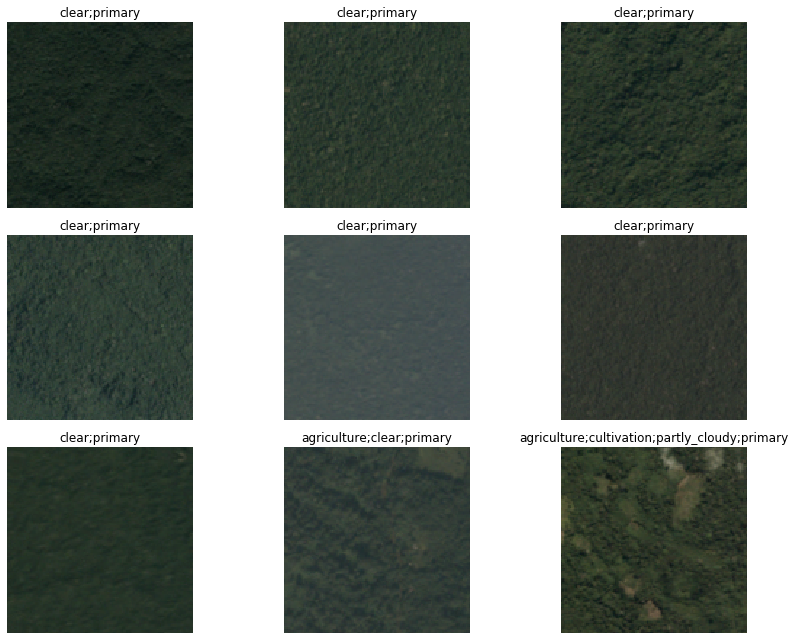

In [15]:
data.show_batch(rows=3, figsize=(12,9))

In [16]:
vortrainiertes_model = models.resnet50

In [17]:
genauigkeit_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(
    data, 
    vortrainiertes_model, 
    metrics=[genauigkeit_02, f_score],
)

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [19]:
learn.recorder.plot(suggestion=True)

Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.02E-02


In [20]:
lr = 0.01

In [21]:
learn.fit_one_cycle(5, slice(lr))

In [22]:
learn.save('stage-1-rn50')

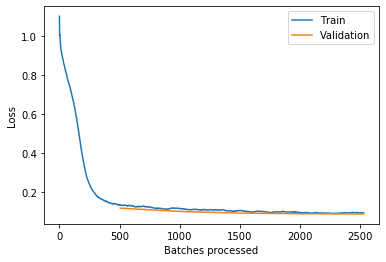

In [23]:
learn.recorder.plot_losses()

In [27]:
learn.recorder.plot_lr()

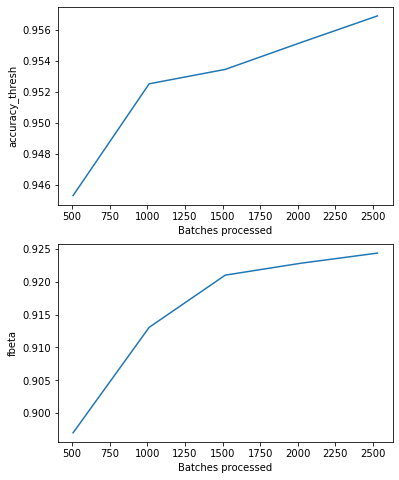

In [28]:
learn.recorder.plot_metrics()

In [35]:
# "fertiges" modell exportieren
learn.export()

### Weitere Schritte...

Üblicherweise würde man noch etwas an den Zahlen schrauben und ein sogenanntes Parameter Tuning machen.
Dies lassen wir bewusst aus, um mehr selbst zu machen.

### Exportiertes Modell verwenden

In [41]:
# speicher ort vom exportierten modell
planet_path = learn.path

In [42]:
# gelerntes modell laden
learn = load_learner(planet_path)

In [43]:
# beispiel Bild laden, hier aus dem Dataset;
# könnte aber auch aus einem Webservice kommen
img = data.train_ds[0][0]
learn.predict(img)

(MultiCategory haze;primary,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]),
 tensor([2.3403e-03, 6.2643e-07, 5.3690e-05, 1.1434e-04, 5.6036e-06, 4.3837e-01,
         3.5184e-04, 9.1403e-07, 1.4455e-03, 2.4214e-04, 6.3998e-01, 4.0375e-04,
         9.9911e-01, 8.1770e-04, 2.7497e-05, 4.5693e-06, 4.6639e-03]))